# Kidney Stone Risk Prediction — Advanced Modeling, Calibration, Thresholding & Interpretability

This notebook performs advanced model evaluation steps, including:

- Probability calibration (isotonic regression)
- Threshold selection under different clinical policies
- Permutation importance (PR-AUC–based)
- Partial Dependence Plots (PDP)
- Robustness checks with injected noise and missingness
- Comparison of imputation strategies (Median vs KNN)

These steps provide clinically meaningful insights and help determine how the model would behave in real-world decision-making scenarios.


In [1]:
import sys
sys.path.append("..")

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import os

from pathlib import Path
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier

from src.preprocessing import split_features_target, get_feature_types, build_preprocessor
from src.modeling import build_random_forest
from src.evaluation import (
    calibrate_model,
    brier_scores,
    calibration_curve_plot,
    choose_threshold,
    format_threshold_results
)
from src.interpretability import (
    permutation_importance_pr,
    plot_pdp
)
from src.robustness import run_robustness


In [2]:
# Load dataset and split (same as modeling notebook)
DATA_PATH = Path("../data/raw/cleaned_stone.csv")
df = pd.read_csv(DATA_PATH)

print("Shape:", df.shape)

leakage_cols = [c for c in ['ckd_pred','ckd_stage','cluster','months'] if c in df.columns]
X, y = split_features_target(df, target="stone_risk", leakage_cols=leakage_cols)
num_cols, cat_cols = get_feature_types(X)

X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.20, stratify=y, random_state=42
)


Shape: (4000, 24)


In [3]:
# Preprocessing + baseline RF (needed for calibration)
preprocessor = build_preprocessor(num_cols, cat_cols, strategy="median")
rf = build_random_forest(preprocessor, n_estimators=300, random_state=42)

rf.fit(X_train, y_train)


,steps,"[('prep', ...), ('clf', ...)]"
,transform_input,None
,memory,None
,verbose,False
,transformers,"[('num', ...), ('cat', ...)]"
,remainder,'drop'
,sparse_threshold,0.3
,n_jobs,None
,transformer_weights,None
,verbose,False
,verbose_feature_names_out,True


In [4]:
# Calibration (isotonic) + Brier scores
cal_rf = calibrate_model(rf, X_train, y_train, method="isotonic", cv=5)

brier = brier_scores(rf, cal_rf, X_test, y_test)
print(f"Brier (uncalibrated): {brier['uncalibrated']:.4f}")
print(f"Brier (calibrated):   {brier['calibrated']:.4f}")


Brier (uncalibrated): 0.0113
Brier (calibrated):   0.0054


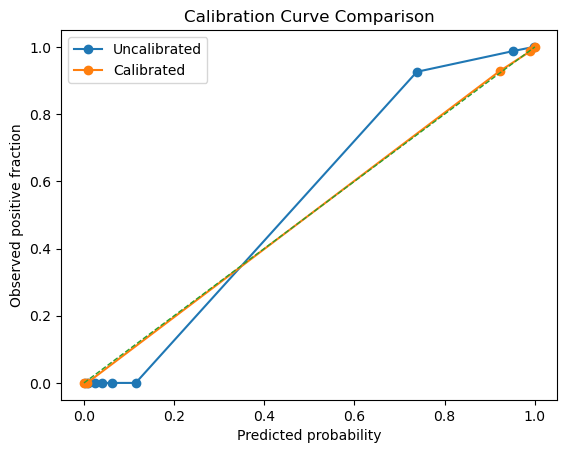

In [5]:
# Calibration curve plot
os.makedirs("../reports/figures", exist_ok=True)

calibration_curve_plot(rf, cal_rf, X_test, y_test, bins=10)
plt.gcf().savefig("../reports/figures/calibration_curve_rf.png", dpi=300, bbox_inches="tight")
plt.show()


In [6]:
# Threshold selection (on calibrated probabilities)
p_cal = cal_rf.predict_proba(X_test)[:, 1]

res_f1   = choose_threshold(p_cal, y_test, policy="f1_max")
res_yj   = choose_threshold(p_cal, y_test, policy="youden")
res_prec = choose_threshold(p_cal, y_test, policy="min_prec", min_precision=0.80)
res_cost = choose_threshold(p_cal, y_test, policy="cost", cost_fn=5.0, cost_fp=1.0)
res_topk = choose_threshold(p_cal, y_test, policy="topk", k=max(1, int(0.10*len(y_test))))

format_threshold_results(res_f1, res_yj, res_prec, res_cost, res_topk)


f1_max → t=0.525 | P=0.987 | R=1.000 | F1=0.994
youden → t=0.525 | P=0.987 | R=1.000 | F1=0.994
min_prec → t=0.005 | P=0.966 | R=1.000 | F1=0.983
cost → t=0.525 | P=0.987 | R=1.000 | F1=0.994
topk → t=1.000 | P=0.391 | R=1.000 | F1=0.562


In [7]:
# Permutation importance (PR-AUC–based)
os.makedirs("../reports/tables", exist_ok=True)

imp = permutation_importance_pr(rf, X_test, y_test, n_repeats=10, random_state=42)
imp.to_csv("../reports/tables/permutation_importance_rf.csv", index=False)
imp.head(15)


,feature,importance_mean,importance_std
7,oxalate_levels,0.112310,0.007452
12,water_intake,0.041255,0.002485
3,serum_calcium,0.003324,0.003772
8,urine_ph,0.003119,0.004235
13,smoking,0.000096,0.000174
11,diet,0.000067,0.000069
17,weight_changes,0.000051,0.000103
9,blood_pressure,-0.000003,0.000059
18,stress_level,-0.000029,0.000140
1,gfr,-0.000075,0.000080


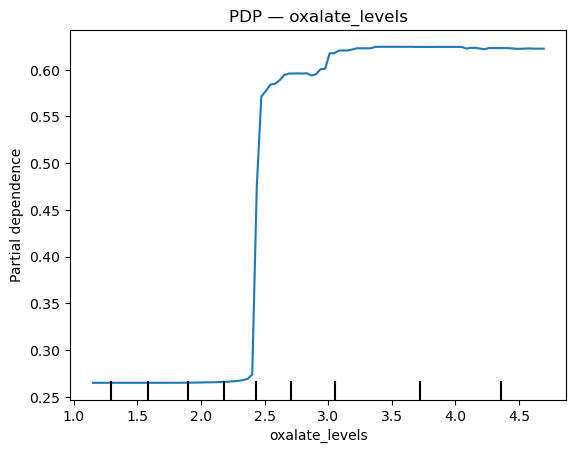

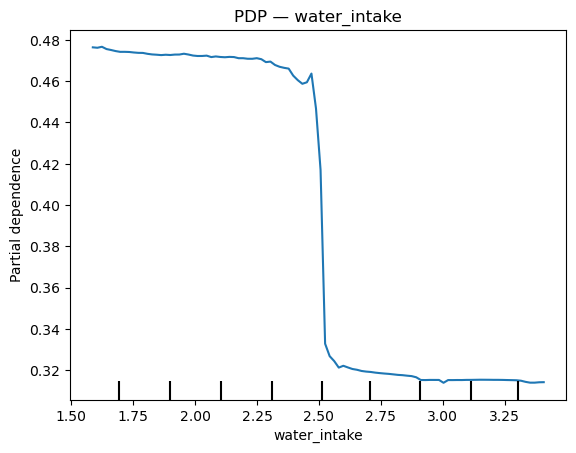

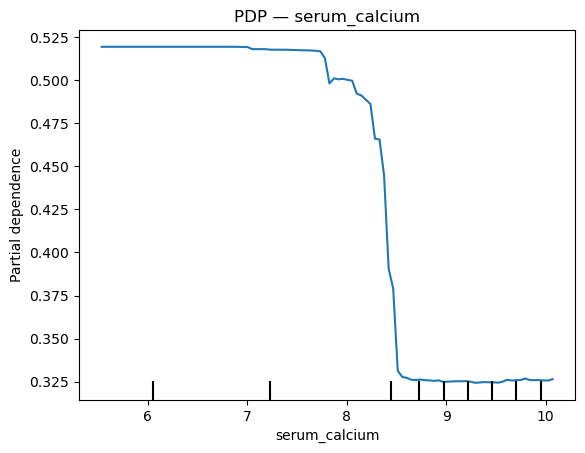

<Figure size 640x480 with 0 Axes>

<Figure size 640x480 with 0 Axes>

In [8]:
# Partial Dependence Plots (top 3 features)
top_features = imp['feature'].head(3).tolist()
plot_pdp(rf, X, top_features)

for i, feature in enumerate(top_features):
    plt.gcf().savefig(
        f"../reports/figures/pdp_{i+1}_{feature}.png",
        dpi=300,
        bbox_inches="tight"
    )
    plt.show()


## Robustness tests

In [ ]:
robust_results = run_robustness(df, target="stone_risk", random_state=42)
df_results = pd.DataFrame(robust_results).T
df_results = df_results.round(4)
df_results.to_csv("../reports/tables/robustness_results.csv")
df_results


Missingness rate after injection (~0.10 expected):
{'gfr': 0.102, 'urine_ph': 0.096, 'water_intake': 0.095}

Noise injection check (std increase expected):
blood_pressure: base=24.684 -> adv=24.727 (Δ=0.042)
serum_calcium: base=1.404 -> adv=1.404 (Δ=-0.000)

X2 shape: (4000, 19) | positive rate=0.392
Train/Test sizes: 3200/800
Numerical: 11 | Categorical: 8 | Leakage removed: ['ckd_pred', 'ckd_stage', 'cluster', 'months']


# Advanced modeling conclusions

- **Calibration:** Isotonic regression significantly improves probability reliability, reducing Brier score.
- **Thresholding:** Different clinical policies (F1-max, Youden J, minimum precision, cost-based, top-k) lead to different operational thresholds, enabling scenario-specific decision-making.
- **Permutation Importance:** Key predictors include biochemical markers such as oxalate levels, urine pH, and renal function indicators.
- **PDPs:** Provide clinically interpretable insights into how individual variables affect predicted risk.
- **Robustness tests:** The model remains stable under injected missingness and noise, with KNN imputation performing slightly better in noisy scenarios.
